# Dominance and satisfaction analysis (AKA filters)

This tutorial provides a practical overview of how to use scikit-criteria for 
satisfaction and dominance analysis, as well as the creation of filters for 
data cleaning.


## Case

In order to decide to purchase a series of bonds, a company studied five 
candidate investments: *PE*, *JN*, *AA*, *FX*, *MM* and *GN*. 

The finance department decides to consider the following criteria for selection. 
selection:

1. **ROE:** Return percentage. Sense of optimality, 
   $Maximize$.
2. **CAP:** Market capitalization. Sense of optimality, $Maximize$.  
3. **RI:** Risk. Sense of optimality, $Minimize$. 

The full decision matrix

In [1]:
import skcriteria as skc

dm = skc.mkdm(
    matrix=[
        [7, 5, 35],
        [5, 4, 26],
        [5, 6, 28],
        [3, 4, 36],
        [1, 7, 30],
        [5, 8, 30],
    ],
    objectives=[max, max, min],
    alternatives=["PE", "JN", "AA", "FX", "MM", "FN"],
    criteria=["ROE", "CAP", "RI"],
)

dm

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FX          3          4        36
MM          1          7        30
FN          5          8        30
[6 Alternatives x 3 Criteria]

## Satisfaction analysis

It is reasonable to think that any decision-maker would want to set 
"satisfaction thresholds" for each criterion, in such a way that alternatives 
that do not  exceed the thresholds in any criterion are eliminated.

The basic idea was proposed in the work of 
"_A Behavioral Model of Rational Choice_"  
<cite data-cite="simon1955behavioral">[simon1955behavioral]</cite> and presents 
the definition of "*aspiration levels*" and are set a priori by the decision maker.


> For our example we will assume that the decision-maker only accepts alternatives 
> with $ROE >= 2%$.

For this analysis we will need the `skcriteria.preprocessing.filters` module .

In [2]:
from skcriteria.preprocessing import filters

The filters are *transformers* and  works as follows:

- At the moment of construction they are provided with a dict that as a key has 
  the name of a criterion, and as a value the condition to be satisfied.
- Optionally it receives a parameter `ignore_missing_criteria` which if it is 
  set to False (default value) fails any attempt to transform an decision 
  matrix that does not have any of the criteria.
- For an alternative not to be eliminated the alternative has to pass all 
  filter conditions. 

The simplest filter consists of instances of the class ``filters.Filters``,
which as a value of the configuration dict, accepts functions that are applied 
to the corresponding criteria and returns a mask where the `True` values denote 
the alternatives that we want to keep.

To write the function that filters the alternatives where $ROE >= 2.

In [3]:
def roe_filter(v):
    return v >= 2  # criteria are numpy.ndarray

flt =  filters.Filter({"ROE": roe_filter})
flt

Filter(criteria_filters={'ROE': <function roe_filter at 0x7f9ee6be4ca0>}, ignore_missing_criteria=False)

However, `scikit-criteria` offers a simpler collection of filters
that implements the most common operations of equality, inequality and 
inclusion a set.

In our case we are interested in the `FilterGE` class, where GE stands for
*Greater or Equal*.

So the filter would be defined as

In [4]:
flt = filters.FilterGE({"ROE": 2})
flt

FilterGE(criteria_filters={'ROE': 2}, ignore_missing_criteria=False)

The way to apply the filter to a `DecisionMatrix`, is like any other 
transformer: 

In [5]:
dmf = flt.transform(dm)
dmf

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FX          3          4        36
FN          5          8        30
[5 Alternatives x 3 Criteria]

As can be seen, we eliminated the alternative `MM` which did not comply with an
$ROE >= 2$.

If on the other hand (to give an example) we would like to filter out the alternatives
$ROE > 3$ and $CAP > 4$ (using the original matrix), we can use the 
filter `FilterGT` where GT is *Greater Than*.

In [6]:
filters.FilterGT({"ROE": 3, "CAP": 4}).transform(dm)

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
AA          5          6        28
FN          5          8        30
[3 Alternatives x 3 Criteria]

<div class="alert alert-info">
**Note:** 

If it is necessary to filter the alternatives by two separate conditions, 
a pipeline can be used. An example of this can be seen below, where we combine 
a satisficing and a dominance filter
</div>

The complete list of filters implemented by Scikit-Criteria is:

- ``filters.Filter``: Filter alternatives according to the value of a criterion 
  using arbitrary functions.

  ```python
  filters.Filter({"criterion": lambda v: v > 1})
  ```

- ``filters.FilterGT``: Filter Greater Than ($>$).
  
  ```python
  filters.FilterGT({"criterion":  1})
  ```

- ``filters.FilterGE``: Filter Greater or Equal than ($>=$).

  ```python
  filters.FilterGE({"criterion":  2})
  ```

- ``filters.FilterLT``: Filter Less Than ($<$).
  
  ```python
  filters.FilterLT({"criterion":  1})
  ```

- ``filters.FilterLE``: Filter Less or Equal than ($<=$).

  ```python
  filters.FilterLE({"criterion":  2})
  ```

- ``filters.FilterEQ``: Filter Equal ($==$).
  
  ```python
  filters.FilterEQ({"criterion":  1})
  ```

- ``filters.FilterNE``: Filter Not-Equal than ($!=$).

  ```python
  filters.FilterNE({"criterion":  2})
  ```

- ``filters.FilterIn``: Filter if the values is in a set ($\in$).
  
  ```python
  filters.FilterIn({"criterion":  [1, 2, 3]})
  ```

- ``filters.FilterNotIn``: Filter if the values is not in a set ($\notin$).

  ```python
  filters.FilterNotIn({"criterion":  [1, 2, 3]})
  ```


## Dominance

An alternative $A_0$ is said to dominate an alternative $A_1$ 
($A_0 \succeq A_1$), if $A_0$ is equal in all criteria and better in at least 
one criterion. On the other hand, $A_0$ strictly dominate $A_1$ 
($A_0$ \succeq A_1$).  $A_1$ ($A_0 \succ A_1$), if $A_0$ is better on all 
criteria than $A_1$.


Under this same train of thought, an alternative that dominates all others is 
called a "_dominant alternative_".  If there is a dominant alternative, it is 
undoubtedly the best choice, as long as a full ranking is not required.

On the other hand, an *alternative is dominated* if there exists at least one 
other alternative that dominates it. If a dominated alternative exists and a 
consigned ordering is not desired, it must be removed from the set of decision 
alternatives. 

Generally only the non-dominated or efficient alternatives are the interested
 ones.

### Scikit-Criteria dominance analysis

Scikit-criteria, contains a number of tools within the attribute,
`DecisionMatrix.dominance`, useful for the evaluation of dominant and dominated 
alternatives.

For example, we can access all the dominated alternatives by using
the `dominated` method

In [7]:
dmf.dominance.dominated()

PE    False
JN    False
AA    False
FX     True
FN    False
dtype: bool

It can be seen with this, that `FX` is an  dominated alternative. In addition 
if  we want to know which are the *strictly dominated* alternatives we need to 
provide the `strict` parameter to the method:

In [8]:
dmf.dominance.dominated(strict=True)

PE    False
JN    False
AA    False
FX     True
FN    False
dtype: bool

It can be seen that *FX* is strictly dominated by at least one other alternative.

If we wanted to find out which are the dominant alternatives of *FX*, 
we can opt for two paths: 

1. List all the dominant/strictly dominated alternatives of 
   *FX* using `dominator_of()`.

In [9]:
dmf.dominance.dominators_of("FX", strict=True)

array(['PE', 'AA', 'FN'], dtype=object)

2. Use `dominance()`/`dominance.dominance()` to see the full relationship 
   between all alternatives.

In [10]:
dmf.dominance(strict=True)  # equivalent to dmf.dominance.dominance()

,PE,JN,AA,FX,FN
PE,False,False,False,True,False
JN,False,False,False,False,False
AA,False,False,False,True,False
FX,False,False,False,False,False
FN,False,False,False,True,False


the result of the method is a 
[DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) 
that in each cell has a `True` value if the _row alternative_ dominates the 
_column alternative_.

If this matrix is very large we can, for example, visualize it in the form of 
a *heatmap* using the library [seaborn](http://seaborn.pydata.org/)

<AxesSubplot:>

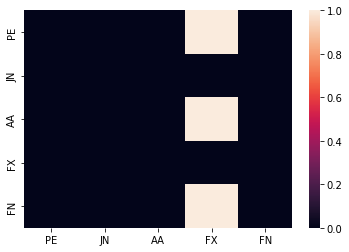

In [11]:
import seaborn as sns
sns.heatmap(dmf.dominance.dominance(strict=True))

Finally we can see how each of the alternatives relate to each other 
dominatnes with *FX* using `compare()`.

In [12]:
for dominant in dmf.dominance.dominators_of("FX"):
    display(dmf.dominance.compare(dominant, 'FX'))

Criteria               Performance
                     ROE    CAP     RI            
Alternatives PE     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

Criteria               Performance
                     ROE    CAP     RI            
Alternatives JN     True  False   True           2
             FX    False  False  False           0
Equals             False   True  False           1

Criteria               Performance
                     ROE    CAP     RI            
Alternatives AA     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

Criteria               Performance
                     ROE    CAP     RI            
Alternatives FN     True   True   True           3
             FX    False  False  False           0
Equals             False  False  False           0

### Filter non-dominated alternatives

Finally skcriteria offers a way to filter non-dominated alternatives,
which it accepts as a parameter if you want to evaluate strict dominance.

In [13]:
flt = filters.FilterNonDominated(strict=True)
flt

FilterNonDominated(strict=True)

In [14]:
flt.transform(dmf)

ROE[▲ 1.0] CAP[▲ 1.0] RI[▼ 1.0]
PE          7          5        35
JN          5          4        26
AA          5          6        28
FN          5          8        30
[4 Alternatives x 3 Criteria]

## Full expermient

We can finally create a complete MCDA experiment that takes into account
the in satisfaction and dominance analysis.

The complete experiment would have the following steps

1. Eliminate alternatives that do not yield at least 2% ($ROE >= $2).
2. Eliminate dominated alternatives.
3. Convert all criteria to maximize.
4. The weights are scaled by the total sum.
5. The matrix is scaled by the vector modulus.
6. Apply [TOPSIS](https://en.wikipedia.org/wiki/TOPSIS).

The most convenient way to do this is to use a pipeline.

In [15]:
from skcriteria.preprocessing import scalers, invert_objectives
from skcriteria.madm.similarity import TOPSIS
from skcriteria.pipeline import mkpipe

pipe = mkpipe(
    filters.FilterGE({"ROE": 2}),
    filters.FilterNonDominated(strict=True),
    invert_objectives.MinimizeToMaximize(),
    scalers.SumScaler(target="weights"),
    scalers.VectorScaler(target="matrix"),
    TOPSIS(),
)

pipe

SKCPipeline(steps=[('filterge', FilterGE(criteria_filters={'ROE': 2}, ignore_missing_criteria=False)), ('filternondominated', FilterNonDominated(strict=True)), ('minimizetomaximize', MinimizeToMaximize()), ('sumscaler', SumScaler(target='weights')), ('vectorscaler', VectorScaler(target='matrix')), ('topsis', TOPSIS(metric='euclidean'))])

We now apply the pipeline to the original data

In [16]:
pipe.evaluate(dm)

,PE,JN,AA,FN
Rank,3,4,2,1


----

In [17]:
import datetime as dt
import skcriteria

print("Scikit-Criteria version:", skcriteria.VERSION)
print("Running datetime:", dt.datetime.now())

Scikit-Criteria version: 0.6dev0
Running datetime: 2022-02-21 15:21:22.346578
